# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard that analyzes the company's latest sales data that can be shared with Regional leads and their respective analysts:**

- Total Sales
- Sales per Region
- Top 5 selling categories for each Region

_delivered orders only_

## Agenda 

[1.0 Dashboard Queries](#1.0-Dashboard-Queries)<br>
&nbsp;[1.1 Total Sales](#1.1-Total-Sales)<br>
&nbsp;[1.2 Sales per Region](#1.2-Sales-per-Region)<br>
&nbsp;[1.3 Top 5 selling categories for each Region](#1.3-Top-5-selling-categories-for-each-Region)<br>
&nbsp;[](#)<br>
&nbsp;[](#)<br>
&nbsp;[](#)<br>


In [1]:
import psycopg2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import date

import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv(os.path.expanduser("-")))

True

In [2]:
conn = psycopg2.connect(host="localhost", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), database='postgres')
cursor = conn.cursor()

In [3]:
def bd_execute(query, has_return=True):
    cursor.execute(query)
    if has_return:
        return [table for table in cursor.fetchall()]

def to_pandas(query_result, columns):
    return pd.DataFrame(query_result, columns=columns)

def write_query(file_name, query):
    with open(f'{file_name}.sql', 'w') as file:
        file.write(query)

def read_query(path):      
    with open(f'{path}', 'r') as file:
        return file.read()
    
def columns(table_name):
        cursor.execute(F"""SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}'""" )
        return [table[0] for table in cursor.fetchall()]
    
def tables():
    cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
    return [table for table in cursor.fetchall()]

def rollback():
    cursor.execute("ROLLBACK;")

## 1.0 Dashboard Queries

Getting the data from PostgreSQL database and saving it to be used in the dashboard.

### 1.1 Total Sales

_from confirmed (delivered) orders_

In [4]:
intial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
sales_per_month_query = f'''
SELECT date_trunc('month', order_purchase_timestamp), SUM(price+freight_value)
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status='delivered' and
      order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')
GROUP BY date_trunc('month', order_purchase_timestamp)
'''
annual_sales = to_pandas(bd_execute(sales_per_month_query), ['month','total_sales']).sort_values('month')

In [5]:
write_query("../sql_queries/sales_per_month_query", sales_per_month_query)
print(read_query("../sql_queries/sales_per_month_query.sql"))


SELECT date_trunc('month', order_purchase_timestamp), SUM(price+freight_value)
FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
WHERE order_status='delivered' and
      order_purchase_timestamp BETWEEN date('2018-01-01') AND date('2019-01-01')
GROUP BY date_trunc('month', order_purchase_timestamp)



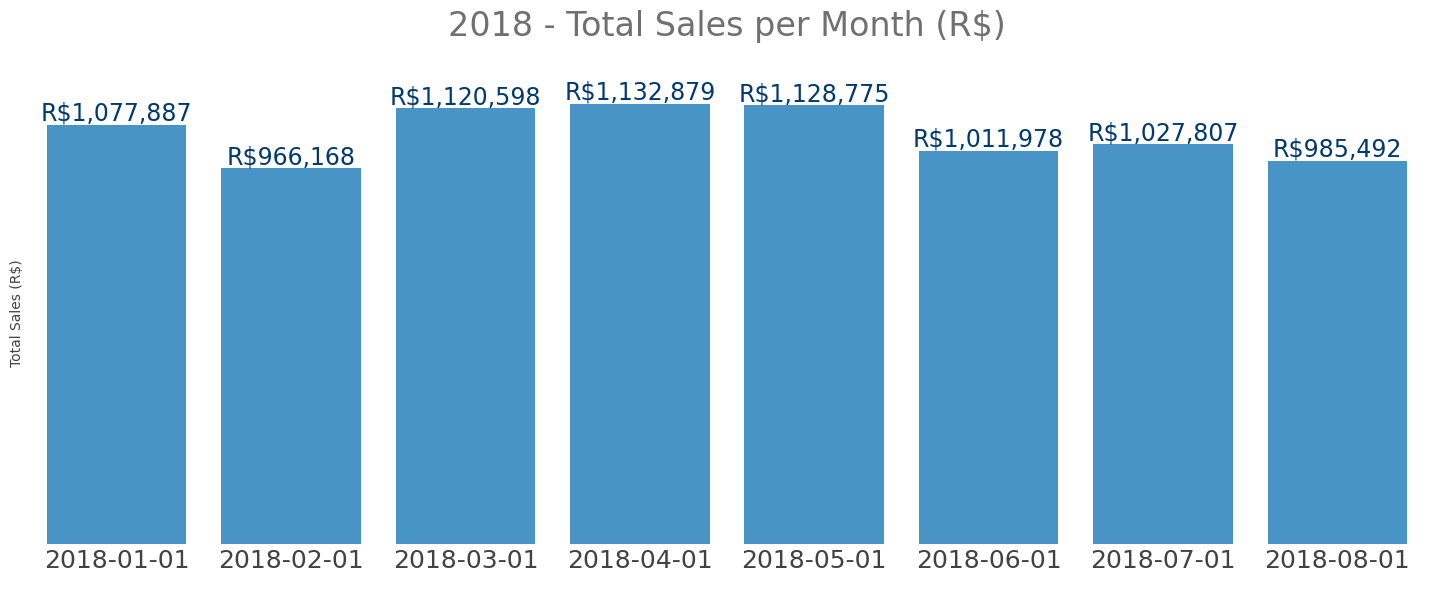

In [7]:
x = list(range(len(annual_sales['month'])))
sales = annual_sales['total_sales'].values
plt.figure(figsize=(18,6))
sns.barplot(data=annual_sales, x=annual_sales['month'].dt.date, y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"2018 - Total Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("R${:,.0f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

### 1.2 Sales per Region

In [13]:
intial_date = date(2018, 1, 1)
final_date = date(2019, 1, 1)
region = 'south'
regional_sales_per_month_query = f'''
SELECT region, date, SUM(total_sales) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               date_trunc('month', order_purchase_timestamp) AS date,
               SUM(price+freight_value) AS total_sales
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
        WHERE order_status='delivered' and
              order_purchase_timestamp BETWEEN date('{intial_date}') AND date('{final_date}')
        GROUP BY customer_state, date_trunc('month', order_purchase_timestamp)
        ) AS states_sales
) AS regional_sales
GROUP BY regional_sales.region, regional_sales.date
HAVING region = '{region}' 
'''

region_sales = to_pandas(bd_execute(regional_sales_per_month_query), ['region', 'month','total_sales']).sort_values('month')
region_sales

,region,month,total_sales
0,south,2018-01-01,151010.12
1,south,2018-02-01,143967.47
2,south,2018-03-01,167915.71
3,south,2018-04-01,186742.47
4,south,2018-05-01,155506.33
5,south,2018-06-01,142384.01
6,south,2018-07-01,138842.58
7,south,2018-08-01,136524.23


In [14]:
write_query(f"../sql_queries/{region}_sales_per_month_query", regional_sales_per_month_query)
print(read_query(f"../sql_queries/{region}_sales_per_month_query.sql"))


SELECT region, date, SUM(total_sales) FROM (
    SELECT *, 
        CASE
             WHEN customer_state IN ('AM','RR','AP','PA','TO','RO','AC') THEN 'north'
                    WHEN customer_state IN ('MA','PI','CE','RN','PE','PB','SE','AL','BA') THEN 'northeast'
                    WHEN customer_state IN ('MT','MS','GO','DF') THEN 'midwest'
                    WHEN customer_state IN ('SP','RJ','ES','MG') THEN 'southeast'
                    WHEN customer_state IN ('PR','RS','SC') THEN 'south'
                    ELSE 'unknown_region'
                END region
    FROM (
        SELECT customer_state,
               date_trunc('month', order_purchase_timestamp) AS date,
               SUM(price+freight_value) AS total_sales
        FROM orders LEFT JOIN order_items ON orders.order_id = order_items.order_id
                    LEFT JOIN customers ON orders.customer_id = customers.customer_id
        WHERE order_status='delivered' and
              order_purchase_timestamp BETWEEN da

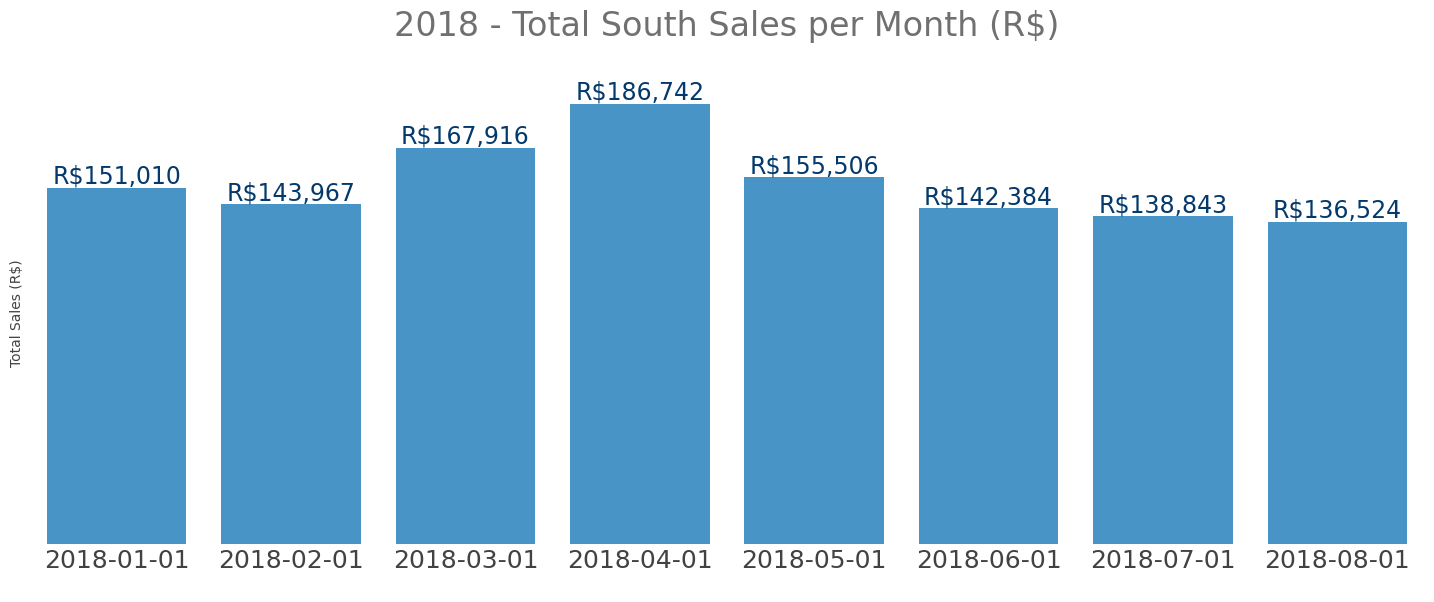

In [9]:
x = list(range(len(region_sales['month'])))
sales = region_sales['total_sales'].values
plt.figure(figsize=(18,6))
sns.barplot(data=region_sales, x=region_sales['month'].dt.date, y='total_sales', color='#3498db');

plt.box(False)
plt.title(f"2018 - Total {region.capitalize()} Sales per Month (R$)\n", fontsize=24, color='#707070')
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel(" ", color='#424242')
plt.ylabel("Total Sales (R$)", color='#424242')
plt.xticks(color="#424242", size=18)
plt.yticks([],[])

for sale_value in range(len(sales)):
    plt.annotate("R${:,.0f}".format(sales[sale_value]), xy=(x[sale_value],sales[sale_value]),
                 ha='center', va='bottom', size=17, color='#03396c')
plt.show()

## 1.3 Top 5 selling categories for each Region